In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N = 60
W, H = 60, 60 
dx = W / N
dy = H / N
dw = N // W
dh = N // H
D0 = 1
D1 = 0.01
tmax = 600
dt = dx**2 * 0.05
#dt = 0.01
itmax = int(tmax / dt)
dt

0.02

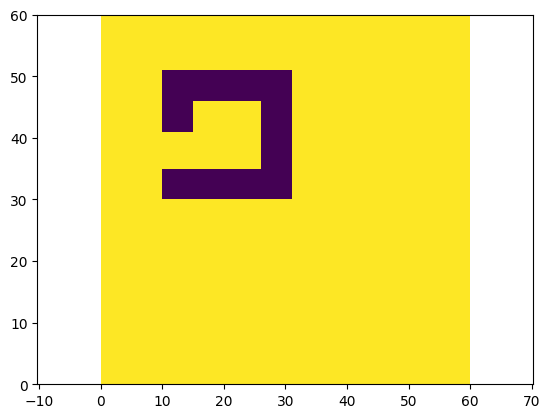

In [3]:
Dij = np.full((N, N), D0)

#Dij[24 * dh : 26 * dh + 1, 25 * dw : 30 * dw + 1] = D1
#Dij[24 * dh : 26 * dh + 1, 25 * dw : 30 * dw + 1] = D1
x = np.arange(0, N)
y = np.arange(0, N)
cx = 90
cy = 90
r = 30
mask = (x[np.newaxis,:]-cx)**2 + (y[:,np.newaxis]-cy)**2 < r**2
#mask1 = (x[np.newaxis,:] - 90)**2 + ((y[:,np.newaxis]-90)-(x[np.newaxis,:]-90)**(2/3))**2 < 1000
mask1 = (x[np.newaxis,:] - 90)**2 + ((y[:,np.newaxis]-90)-((x[np.newaxis,:]-90)**2)**(1/3))**2 < 1000
mask2 = (x[np.newaxis,:] - 120)**2 + (1.5*(y[:,np.newaxis]-100) - (200 * (np.abs(x[np.newaxis,:]-120))) ** (1/2)) ** 2 < 2000
#Dij[mask2] = D1

Dij[30 * dh : 50 * dh + 1, 10 * dw : 30 * dw + 1] = D1
Dij[35 * dh : 45 * dh + 1, 15 * dw : 25 * dw + 1] = D0
Dij[35 * dh : 40 * dh + 1, 10 * dw : 15 * dw + 1] = D0

#Dij[20 * dh : 40 * dh + 1, 13 * dw : 33 * dw + 1] = D1
#Dij[20 * dh : 35 * dh + 1, 14 * dw : 28 * dw + 1] = D0
#Dij[25 * dh : 38 * dh + 1, 13 * dw : 18 * dw + 1] = D0
plt.axis('equal')
plt.pcolormesh(Dij)
plt.show()

In [4]:
from numba import njit, prange
@njit(parallel=True)
def  diffuse_step(it, T, dx, dt, D):
    prev = it % 2
    cur = (it + 1) % 2

    for i in prange(1, N-1):
        for j in range(1, N-1):
            g = dt * Dij[i, j] / dx**2
            T[cur, i, j] = T[prev, i, j]   + g * (
                         T[prev, i + 1, j] +
                         T[prev, i - 1, j] +
                         T[prev, i, j - 1] +
                         T[prev, i, j + 1] -
                     4 * T[prev, i, j]           )

In [5]:
def bound_cond(T):
    T[:, 0, :] = T[:, 1, :]
    T[:, -1, :] = T[:, -2, :]
    T[:, :, 0] = T[:, :, 1]
    T[:, :, -1] = T[:, :, -2]

In [6]:
h0xl = 5
h0xr = 10
h0yl = 20
h0yu = 40
p0 = 100
theta0 = 43

h1xl = 20
h1xr = 40
h1yl = 5
h1yu = 10
p1 = 100
theta1 = 77

In [7]:
def q(p, theta, dt):
    return p * (np.sin(2 * np.pi * dt / theta) + 1)

In [8]:
def heat(T, xl, xr, yl, yu, p, theta, it, dt):
    T[:, yl * dh : yu * dh, xl * dw : xr * dw] += dt * q(p, theta, it * dt)

In [9]:
from tqdm import trange

T = np.zeros((2, N, N))
res0 = []
res1 = []
res2 = []
res3 = []
for it in trange(itmax):
    
    bound_cond(T)
    diffuse_step(it, T, dx, dt, Dij)
    heat(T, h1xl, h1xr, h1yl, h1yu, p1, theta1, it, dt)
    heat(T, h0xl, h0xr, h0yl, h0yu, p0, theta0, it, dt)

    res0.append(T[0, 20 * dh, 20 * dw])
    res1.append(T[0, 20 * dh, 40 * dw])
    res2.append(T[0, 40 * dh, 40 * dw])
    res3.append(T[0, 40 * dh, 20 * dw])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [00:03<00:00, 8351.31it/s]


2328.3882987121697
2178.4298443743205
413.4197169808943
11.758905605551105


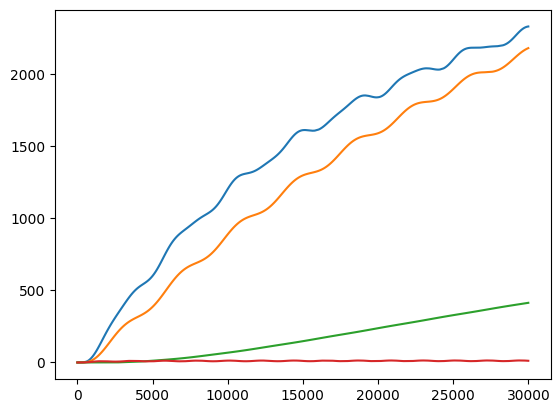

In [10]:
plt.plot(res0)
plt.plot(res1)
plt.plot(res2)
plt.plot(res3)
print(res0[-1])
print(res1[-1])
print(res2[-1])
print(res3[-1])

5369.229801059955
1593.453607172598
0.0


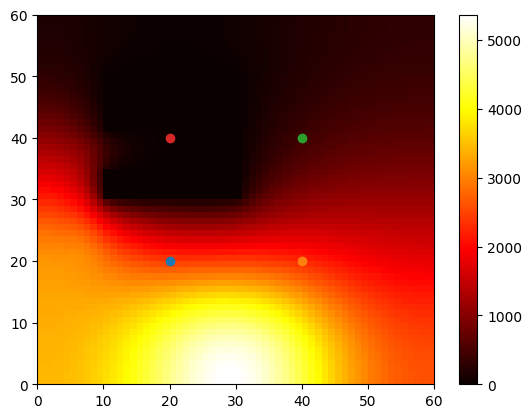

In [11]:
plt.pcolormesh(T[0], cmap='hot')
print(np.max(T[0]))
print(np.mean(T[0]))
print(np.min(T[0]))
plt.colorbar()
plt.scatter(20 * dh, 20 * dw)
plt.scatter(40 * dh, 20 * dw)
plt.scatter(40 * dh, 40 * dw)
plt.scatter(20 * dh, 40 * dw)